### Preparation

In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from train_arg_parser import get_args_parser
from models.model_configs import instantiate_model

from training.eval_loop import eval_model
from train import get_data_loader

# redirect logging in this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = []
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
handler.setFormatter(logging.Formatter('%(asctime)s - %(filename)s - %(levelname)s: %(message)s'))
logger.addHandler(handler)

### Load checkpoint

In [ ]:
# Parse arguments
args = get_args_parser().parse_args([])
args.use_edm_aug = True
args.distributed = False

chkpt = "tmp/model.pth"

# If not having downloaded the checkpoint:
%pip install -q gdown
import gdown
import os
if not os.path.exists(chkpt):
    gdown.download(f"https://drive.google.com/uc?id=1Ev9aZdt7hNVkOfaTQ7rrLAqs3jA_vnvj", output=chkpt, quiet=False)

checkpoint = torch.load(chkpt, map_location="cpu", weights_only=False)

model = instantiate_model(args)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.load_state_dict(checkpoint["model"])
epoch = checkpoint["epoch"] + 1

print('Checkpoint loaded.')

Note: you may need to restart the kernel to use updated packages.


Checkpoint loaded.


### Generation Demo

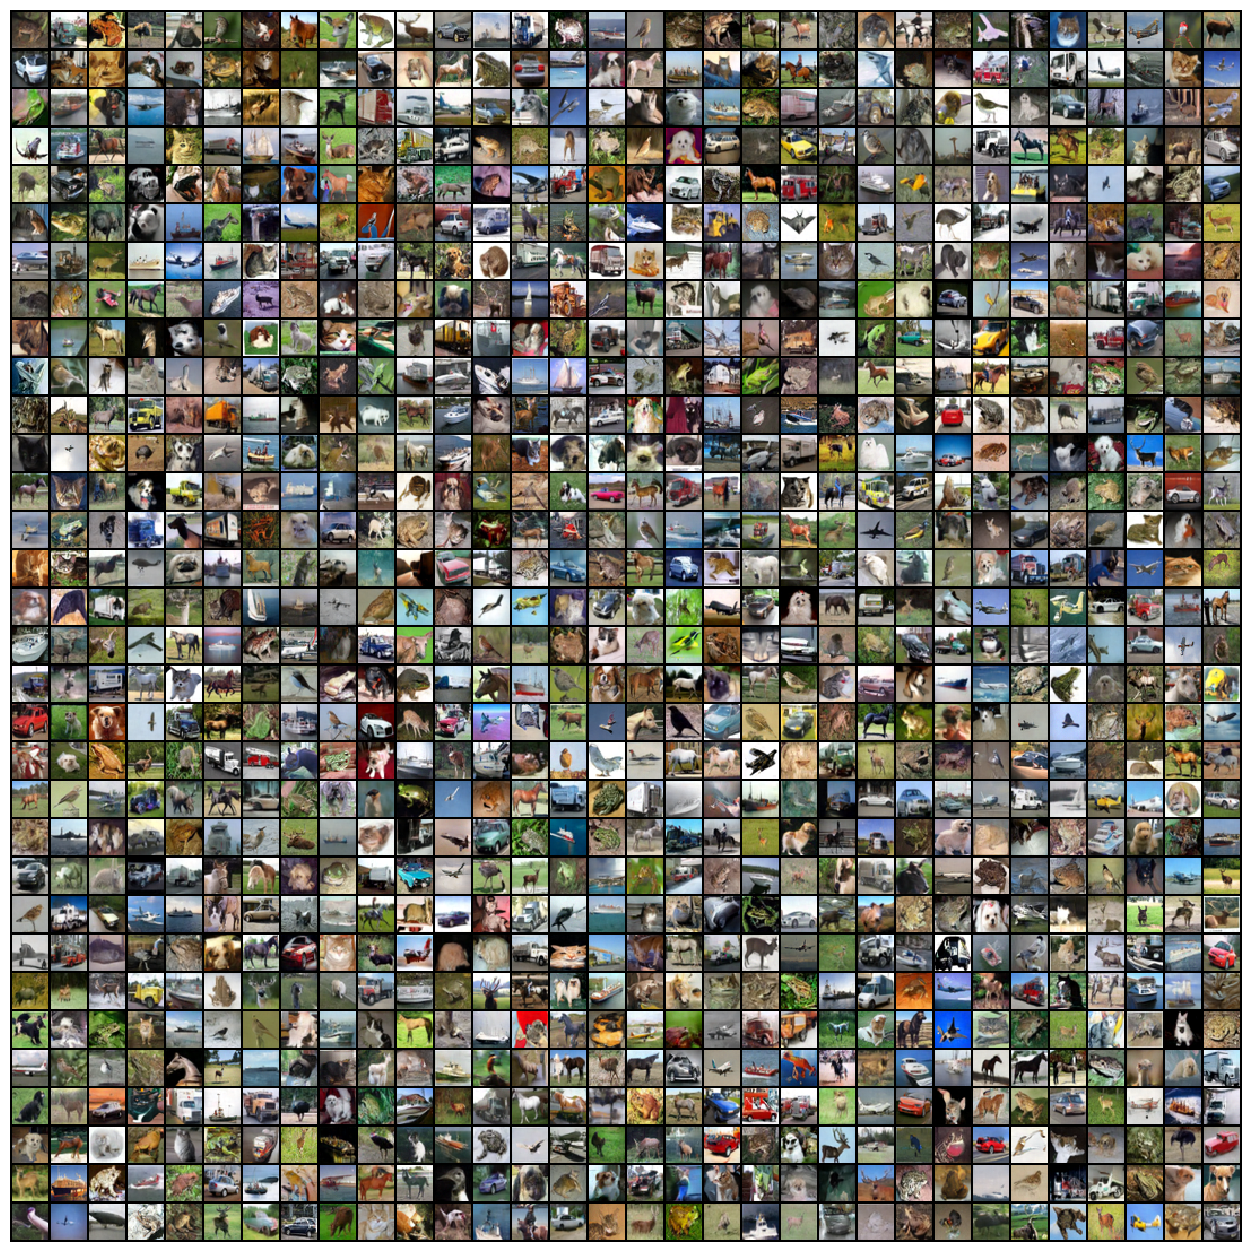

In [3]:
nrow = 32
num_samples = nrow**2
torch.manual_seed(0)
with torch.no_grad():
    imgs = model.sample(samples_shape=(num_samples, 3, 32, 32), net=model.net_ema1, device=device)

imgs = torch.clamp(imgs * 0.5 + 0.5, min=0.0, max=1.0)
imgs = torch.floor(imgs * 255)
imgs = imgs.to(torch.uint8)

grid = make_grid(imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(nrow / 2, nrow / 2))
plt.imshow(grid, interpolation='none')
plt.axis('off')
plt.show()


### Evaluate FID

In [4]:
args.batch_size = 128
args.compute_fid = True
args.seed = 0

data_loader_fid = get_data_loader(args, is_for_fid=True)
net_eval = model.net_ema1
eval_stats = eval_model(
    model,
    net_eval,
    data_loader_fid,
    device,
    epoch=epoch,
    args=args,
    suffix=f'_ema{model.net_ema.ema_decay}',
)
print(f"FID_ema{net_eval.ema_decay}: {eval_stats['fid']}")

2025-07-24 12:15:04,999 - train.py - INFO: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )
2025-07-24 12:15:05,000 - train.py - INFO: Intializing DataLoader


2025-07-24 12:15:05,001 - train.py - INFO: <torch.utils.data.distributed.DistributedSampler object at 0x7fae860c5070>
2025-07-24 12:15:13,748 - eval_loop.py - INFO: Evaluating: current batch 128,  [1280/50000], running fid 37.64066696166992
2025-07-24 12:15:18,896 - eval_loop.py - INFO: Evaluating: current batch 128,  [2560/50000], running fid 20.778017044067383
2025-07-24 12:15:24,031 - eval_loop.py - INFO: Evaluating: current batch 128,  [3840/50000], running fid 14.657516479492188
2025-07-24 12:15:29,190 - eval_loop.py - INFO: Evaluating: current batch 128,  [5120/50000], running fid 11.467696189880371
2025-07-24 12:15:34,439 - eval_loop.py - INFO: Evaluating: current batch 128,  [6400/50000], running fid 9.555079460144043
2025-07-24 12:15:39,678 - eval_loop.py - INFO: Evaluating: current batch 128,  [7680/50000], running fid 8.230422973632812
2025-07-24 12:15:44,891 - eval_loop.py - INFO: Evaluating: current batch 128,  [8960/50000], running fid 7.365575313568115
2025-07-24 12:15:5

FID_ema0.99995: 2.796400308609009
